[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSinger04/VOGUE-Reimplementation/blob/main/cryu854/Image2Latent.ipynb)

# Prerequisites

A Google Drive account is needed for this notebook to be run. In the cell under "Mount drive for dataset and weights", please state under ```PRT_DIRS``` as key your identifier (e.g. "hermann") and as value a directory dedicated to this notebook (e.g. "Latent2Images"). Then, set ```PRT_DIR = PRT_DIRS[<your_identifier>]```  Then, go to 
https://drive.google.com/drive/folders/1u2xu7bSrWxrbUxk-dT-UvEJq8IjdmNTP, right-click on "ffhq-dataset" at "Shared with me > ffhq-dataset" and click on "Add a shortcut to Drive". Create the shortcut the directory dedicated to this notebook. Please go to https://drive.google.com/drive/folders/1BO98vdtQSUjRKqlIIoiRVtBM_mCEcoFc and do the same as you did with "ffhq-dataset" with "official_1024x1024" at "Shared with me > StyleGAN2models > weights-ffhq > official_1024x1024". Do the same with https://drive.google.com/drive/folders/1-0uzbtuEQkKNbuO-o4-Ly2DJZtsL7Cyy?usp=sharing and https://drive.google.com/drive/folders/1w158HtXV6Z1TH0PRdByiz6P1K8FhyQyq?usp=sharing.

This is needed, as "ffhq-dataset" points to the training dataset which is too large to download / upload oneself, "official_1024x1024" contains weights for the StyleGAN2 generator used in this notebook and also, tensorboard logs and training variables (e.g. encoder weights) get saved in the folder dedicated to this notebook.

When you run the cell under "Mount drive for dataset and weights", you will need to MANUALLY authenticate access to Google Drive.


## Mount drive for dataset and weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PRT_DIRS = {"hermann": "/content/drive/MyDrive/Lernen/Coxi/IANNwTF/",
            "hermann2": "/content/drive/MyDrive/Latent2Images/"}
# parent directory of "ffhq-dataset", "official_1024x1024", "logs"
PRT_DIR = PRT_DIRS["hermann"]

Mounted at /content/drive


In [ ]:
%cd /content
!git clone https://github.com/HSinger04/VOGUE-Reimplementation

/content
fatal: destination path 'VOGUE-Reimplementation' already exists and is not an empty directory.


In [ ]:
%cd /content/VOGUE-Reimplementation/cryu854/

/content/VOGUE-Reimplementation/cryu854


## Imports

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import \
BatchNormalization, ELU, Conv2D, Input, Layer, Concatenate, \
GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model

## Debug control

In [ ]:
# Set to True if you want to deactivate tf.function for debugging, else leave at False
tf.config.run_functions_eagerly(False)

# Data preparation

## Load data

In [ ]:
# Pro: Save space in google drive
# Contra: Needs to load the whole dataset every time
# use list_files to get generate dataset from data in different subdirectories easily
data = tf.data.Dataset.list_files(PRT_DIR + "ffhq-dataset/images1024x1024/" 
                                  + "[0-9]" * 2
                                  + "000/*.png")

## Data pipeline

In [ ]:
# Data pipeline constants
# shuffle_size shouldn't be much higher than 100. Otherwise, Google Colab runs out of memory
shuffle_size = 100
BATCH_SIZE = 2
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE

In [ ]:
def decode_ffhq(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    return img

# Convert paths to image
data = data.map(decode_ffhq)

In [ ]:
# TODO: Show some images

In [ ]:
# Normalize to [-1, 1] to match StyleGAN2's generator's output
data = data.map(lambda x: (tf.cast(x, tf.float32) / 127.5) - 1)
# Shuffle whole dataset once
#data = data.shuffle(buffer_size=shuffle_size)
data = data.batch(BATCH_SIZE)
# Shuffle batch each iteration 
# TODO: left out for now due to memory issues
#data = data.shuffle(buffer_size=shuffle_size, reshuffle_each_iteration=True)
#data = data.prefetch(PREFETCH_SIZE)

# Loading trained StyleGAN2 Generator

## Actually load the model

In [ ]:
!git pull
import tensorflow as tf
from modules.generator import generator

resolution = 1024  
config = "f"
num_labels = 0
checkpoint_path = PRT_DIR + "official_1024x1024/"

Gs = generator(resolution, num_labels, config, randomize_noise=False)
ckpt = tf.train.Checkpoint(generator_clone=Gs)
print(f'Loading network from {checkpoint_path}...')
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()
# Freeze Generator since we don't want to train it
Gs.trainable = False

Already up to date.
Loading network from /content/drive/MyDrive/Lernen/Coxi/IANNwTF/official_1024x1024/...


## Generate and show images

In [ ]:
# returns image in the correct range of 0 to 225
@tf.function
def get_img(x, truncation_psi, training=False):
    # TODO: change comment below better
    # Generator returns values that should be clipped to -1 and 1
    img = Gs(x, truncation_psi=truncation_psi, training=training)
    img = tf.clip_by_value(img, clip_value_min=-1.0, clip_value_max=1.0)
    return img

In [ ]:
truncation_psi = 0.5
latent_size = 512
latents = tf.random.normal([BATCH_SIZE, latent_size])
labels_indice = [0]*BATCH_SIZE
labels = tf.zeros([BATCH_SIZE, 0], tf.float32)
# Generate images
images = get_img([latents, labels], truncation_psi)

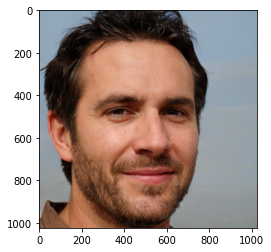

In [ ]:
from matplotlib import pyplot as plt

# TODO: proper image displaying
for i in range(BATCH_SIZE):
    temp = images[i]
    temp = (temp + 1) * 127.5
    plt.imshow(temp.numpy().astype(np.uint8))
    break

# Training preparation

## Load network for perceptual loss and freeze it 

In [ ]:
# TODO: remove unnecessary layers
perc_base_net = tf.keras.applications.EfficientNetB0()
# Freeze perc_base_net since we don't want to train it
perc_base_net.trainable = False

In [ ]:
layer_names = ("block1a_project_conv", "block2b_project_conv", "block3b_project_conv", 
               "block4c_project_conv", "block5c_project_conv", "block6d_project_conv",
               "block7a_project_conv")

# layer_indices = []
used_layers = []

# for i, layer in enumerate(vgg.layers):
#     used_layers.append(layer)
#     if layer.name in layer_names:
#         layer_indices.append(i)
#         if len(layer_indices) == len(layer_names):
#             break

used_layers = [perc_base_net.get_layer(layer_name).output for layer_name in layer_names]

perc_net = tf.keras.Model(inputs=perc_base_net.inputs, outputs=used_layers)

# Hopefully save memory this way         
del perc_base_net
tf.keras.backend.clear_session()

NUM_LAYERS = len(layer_names)

## Define perceptual loss

In [ ]:
@tf.function
def perc_loss(real, fake):
    # TODO: Better description. Also maybe more detail? Point to equation
    """Returns perceptual loss according to VGG16 activations. See 
    """
    
    real = tf.image.resize(real, [224, 224])
    real = tf.keras.applications.efficientnet.preprocess_input(real)

    fake = tf.image.resize(fake, [224, 224])
    fake = tf.keras.applications.efficientnet.preprocess_input(fake)

    real = perc_net(real)
    fake = perc_net(fake)

    real_out = real[0]
    fake_out = fake[0]

    # normalize in channel dimension
    layer_loss = tf.math.l2_normalize(real_out, axis=-1)
    layer_loss -= tf.math.l2_normalize(fake_out, axis=-1)

    layer_loss = tf.norm(layer_loss, axis=-1)
    layer_loss = tf.square(layer_loss)
    layer_loss = tf.reduce_mean(layer_loss)

    loss = layer_loss

    for i in range(1, NUM_LAYERS):
        real_out = real[i]
        fake_out = fake[i]

        # normalize in channel dimension
        layer_loss = tf.math.l2_normalize(real_out, axis=-1)
        layer_loss -= tf.math.l2_normalize(fake_out, axis=-1)

        layer_loss = tf.norm(layer_loss, axis=-1)
        layer_loss = tf.square(layer_loss)
        layer_loss = tf.reduce_mean(layer_loss)

        loss = loss + layer_loss

    return loss         

## Instantiate loss trackers

In [ ]:
GLOBAL_LOSS_TRACKER = tf.keras.metrics.Mean()

## Instantiate train writer

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Set log directory
LOG_DIR = PRT_DIR + "logs/encoder/" + current_time 

TRAIN_WRITER = tf.summary.create_file_writer(LOG_DIR)

## Instantiate optimizer

In [ ]:
LEARNING_RATE = 0.001
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)

## Instantiate encoder

In [ ]:
ENCODER = tf.keras.Sequential([Conv2D(512, 2, strides=2),
                               BatchNormalization(),
                               ELU(),
                               Conv2D(512, 2, strides=2),
                               BatchNormalization(),
                               ELU(),
                               Conv2D(512, 2, strides=2),
                               BatchNormalization(),
                               # Leave out ELU because it has trouble producing big negative values
                               GlobalAveragePooling2D()])

## Define and potentially restore checkpoint

In [ ]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=OPTIMIZER, net=ENCODER, iterator=data)
manager = tf.train.CheckpointManager(ckpt, PRT_DIR + 'tf_ckpts', max_to_keep=3)

# assert consumed throws error at optimizer, but that's not a problem
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))

Restored from /content/drive/MyDrive/Lernen/Coxi/IANNwTF/tf_ckpts/ckpt-5


# Check Encoder outputs

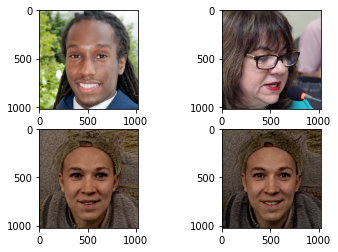

In [ ]:
datum = next(iter(data))

datum_latents = ENCODER(datum)

restored_imgs = get_img([datum_latents, labels], truncation_psi=truncation_psi)
restored_imgs = (restored_imgs + 1) * 127.5
restored_imgs = restored_imgs.numpy().astype(np.uint8)

datum = (datum + 1) * 127.5
datum = datum.numpy().astype(np.uint8)

fig, ax = plt.subplots(2, BATCH_SIZE)

for i, fake_img in enumerate(restored_imgs):
    ax[0][i].imshow(datum[i])
    ax[1][i].imshow(fake_img)

# Train

In [ ]:
@tf.function 
def encoder_train_step(model, inputs, optimizer, global_loss_tracker):
    with tf.GradientTape() as tape:

        # perc
        fakes = model(inputs)
        fakes = get_img([fakes, labels], truncation_psi)
        loss = perc_loss(inputs, fakes)
        # TODO: Confirm perc_loss output is scalar
        # average over the batch manually
        # TODO: remove
        #loss = tf.math.reduce_mean(loss)
        # TODO: remove
        gradients = tape.gradient(loss, model.trainable_variables)
        

    # update weights  
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # record global loss
    global_loss_tracker.update_state(loss)

In [ ]:
# We do not iterate over multiple epochs, as a single one already takes 10 hours+,
# so google colab won't even let us do a full epoch 
for i, inputs in enumerate(data):
    encoder_train_step(ENCODER, inputs, OPTIMIZER, GLOBAL_LOSS_TRACKER) 
    # record every 1750th step, which is between 30 and 60 minutes of training time
    if i % 1750 == 0 and not i == 0:
        # write average epoch loss
        with TRAIN_WRITER.as_default():
            tf.summary.scalar('loss', GLOBAL_LOSS_TRACKER.result(), step=i) 
            
            # save model
            manager.save()
            print("Saved model at i == " + str(i) + ", Current time: " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

        # reset statistics
        GLOBAL_LOSS_TRACKER.reset_states()

Saved model at i == 1750, Current time: 20210330-100510


KeyboardInterrupt: ignored